## Forecasting for AIR ML   

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from autots import AutoTS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
#from pmdarima import auto_arima
color_pal = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
path = r"D:\OneDrive - Wipro\Desktop\AIR\\"
infile =  path + "AIR_WDC_today_Q1Q2Q3.csv"

#r"D:\OneDrive - Wipro\Desktop\AIR\AIR_WDC_today_Q1Q2Q3.csv"

#table = pd.read_csv(infile, engine='python',sep=',', quotechar='"', error_bad_lines=False)

table_chunk = pd.read_csv(infile, engine='python', sep=',', chunksize=2000000)
table = pd.concat(list(table_chunk))

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

table.head()

,LOAD_DATE,SR_GUID,PROJECT_NUMBER,PROJECT_NAME,PROJECT_DESCRIPTION,CUSTOMER_NO,CUSTOMER_NAME,INDENT_STATUS,PROJECT_PROFIT_CENTER,PROJECT_PROFIT_CENTER_DESCRIPTION,...,SL_OPS_PC_DESC,SL_OPS_SERVICE_LINE,SLWBS,REPORT_TIME,SL_OPS_GBL,SL_DM_ID,SL_DM_NAME,SL_PM_ID,SL_PM_NAME,SOW_OWNER_EMAIL
0,2025-03-08,037817F5F7F91EEEBC836BD174C8E955,358149.0,49722/DG/P05/B47/S50,ANZ-RLA-AMS- Support1,31004.0,RESOLUTION LIFE SERVICES AUSTRALIA,RECRUIT,PC36400,APMEA,...,WIPRO FULLSTRIDE CLOUD,FSC - WDC,49722/P05/B47/SL02,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-08,037817F5F7F91EEEBC984EDC9427AA55,399689.0,27266/P05/B05/S80,E2E Testing consolidation,26555.0,T-Mobile USA Inc.,RECRUIT,PC30200,AMERICAS 1,...,NaN,NaN,NaN,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-08,037817F5F7F91EEEBC9EFC3DDF02AA58,307434.0,37456/DG/P03/B02/S80,Assurance Main,10761.0,Aviva Life Services UK Limited,INTERNAL,PC34100,EUROPE,...,NaN,NaN,NaN,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-08,037817F5F7F91EEF84AD5879362E0CC4,433386.0,WBS120240418134724,Care Solution 2024-2026,11237.0,"United HealthCare Services, Inc.",INTERNAL,PC30100,AMERICAS 1,...,WIPRO FULLSTRIDE CLOUD,FSC - WDC,39808/P05/B02/SL04,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-08,037817F5F7F91EEEBC9CE64239CFAA58,221717.0,17990/P03/B02/S35,CIMIC_T&M_2022-2023_AppDev,71276.0,CIMIC GROUP LTD,INTERNAL,PC36400,APMEA,...,WIPRO FULLSTRIDE CLOUD,FSC - WDC,17990/P03/B02/SL03,08-MAR-2025 01:14:22,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = table[['INDENT_CREATED_ON','ESSENTIAL_SKILL','NO_OF_RESOURCES','INDENT_STATE']]

In [6]:
df.rename(columns={'INDENT_CREATED_ON': 'Date'}, inplace=True)
df.rename(columns={'NO_OF_RESOURCES': 'Total'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22221 entries, 0 to 22220
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             22221 non-null  object
 1   ESSENTIAL_SKILL  22221 non-null  object
 2   Total            22221 non-null  int64 
 3   INDENT_STATE     22221 non-null  object
dtypes: int64(1), object(3)
memory usage: 694.5+ KB


In [7]:
df['Date'] = pd.to_datetime(df.Date)

In [9]:
tmpdf = df[df['ESSENTIAL_SKILL'] == '.NET']
tmpdf

,Date,ESSENTIAL_SKILL,Total,INDENT_STATE
4,2024-04-02,.NET,1,CANCELLED
7,2024-05-28,.NET,1,CANCELLED
17,2024-04-23,.NET,2,CANCELLED
24,2024-04-10,.NET,1,CANCELLED
30,2024-04-10,.NET,2,FULFILLED
...,...,...,...,...
22065,2024-12-18,.NET,1,FULFILLED
22069,2024-12-19,.NET,1,PENDING
22083,2024-10-14,.NET,2,PENDING
22106,2024-11-12,.NET,3,PENDING


In [10]:
tmpdf = tmpdf.groupby("Date").sum()
tmpdf = tmpdf.sort_index()
tmpdf = tmpdf['2024-04-01':'2025-12-31'].resample('D').sum()
tmpdf.head()

,ESSENTIAL_SKILL,Total,INDENT_STATE
Date,,,
2024-04-02,.NET.NET,2,CANCELLEDCANCELLED
2024-04-03,.NET.NET.NET.NET.NET.NET.NET,7,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-04-04,.NET.NET.NET.NET.NET.NET.NET.NET,9,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-04-05,.NET.NET.NET.NET.NET.NET.NET.NET,8,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-04-06,0,0,0


In [11]:
tmpdf['ESSENTIAL_SKILL'] = ".NET"
tmpdf

,ESSENTIAL_SKILL,Total,INDENT_STATE
Date,,,
2024-04-02,.NET,2,CANCELLEDCANCELLED
2024-04-03,.NET,7,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-04-04,.NET,9,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-04-05,.NET,8,CANCELLEDCANCELLEDCANCELLEDCANCELLEDCANCELLEDC...
2024-04-06,.NET,0,0
...,...,...,...
2024-12-26,.NET,2,CANCELLEDCANCELLED
2024-12-27,.NET,0,0
2024-12-28,.NET,0,0


In [13]:
tdf = tmpdf['Total']

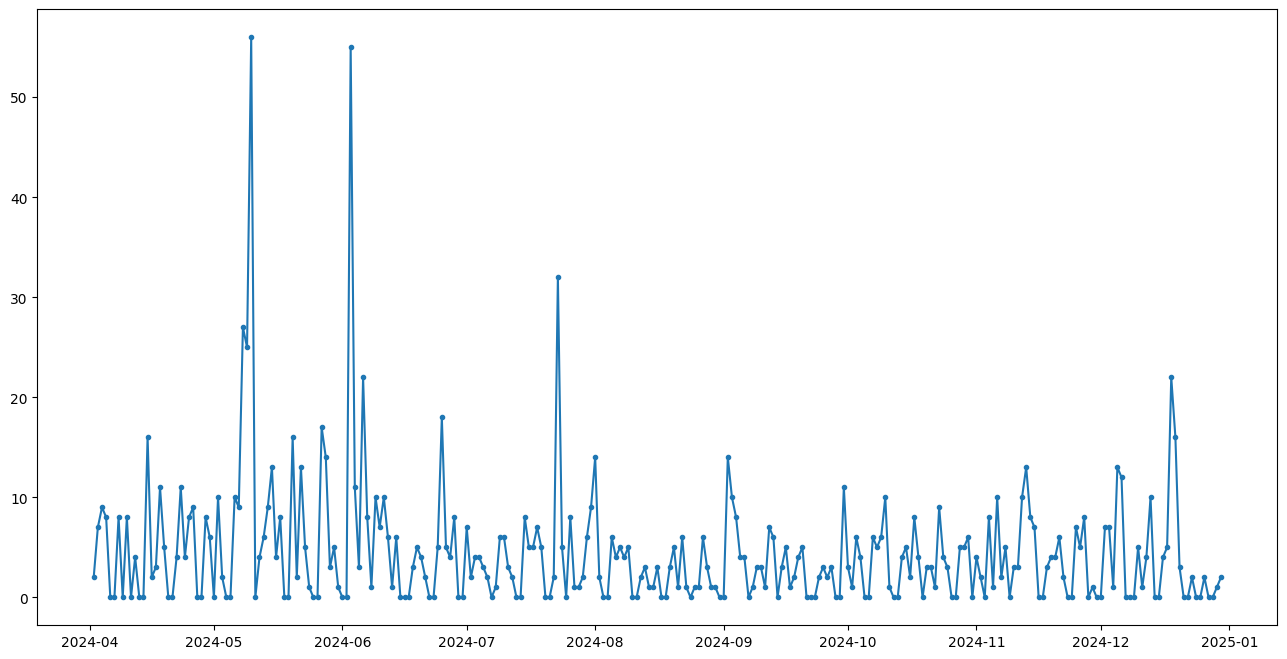

In [16]:
plt.figure(figsize=(16,8))
plt.plot(tdf, label='Open Position Trend', marker='.')


In [17]:
def add_features(af):
    af['MA7'] = af['Total'].rolling(window=7).mean()
    af['MA30'] = af['Total'].rolling(window=30).mean()
    af['STD7'] = af['Total'].rolling(window=7).std()
    return af

In [28]:
tdf = add_features(tmpdf)
tdf = tdf[["ESSENTIAL_SKILL","Total","MA7","MA30","STD7"]]
tdf

,ESSENTIAL_SKILL,Total,MA7,MA30,STD7
Date,,,,,
2024-04-02,.NET,2,NaN,NaN,NaN
2024-04-03,.NET,7,NaN,NaN,NaN
2024-04-04,.NET,9,NaN,NaN,NaN
2024-04-05,.NET,8,NaN,NaN,NaN
2024-04-06,.NET,0,NaN,NaN,NaN
...,...,...,...,...,...
2024-12-26,.NET,2,1.000000,4.100000,1.290994
2024-12-27,.NET,0,0.571429,3.833333,0.975900
2024-12-28,.NET,0,0.571429,3.833333,0.975900


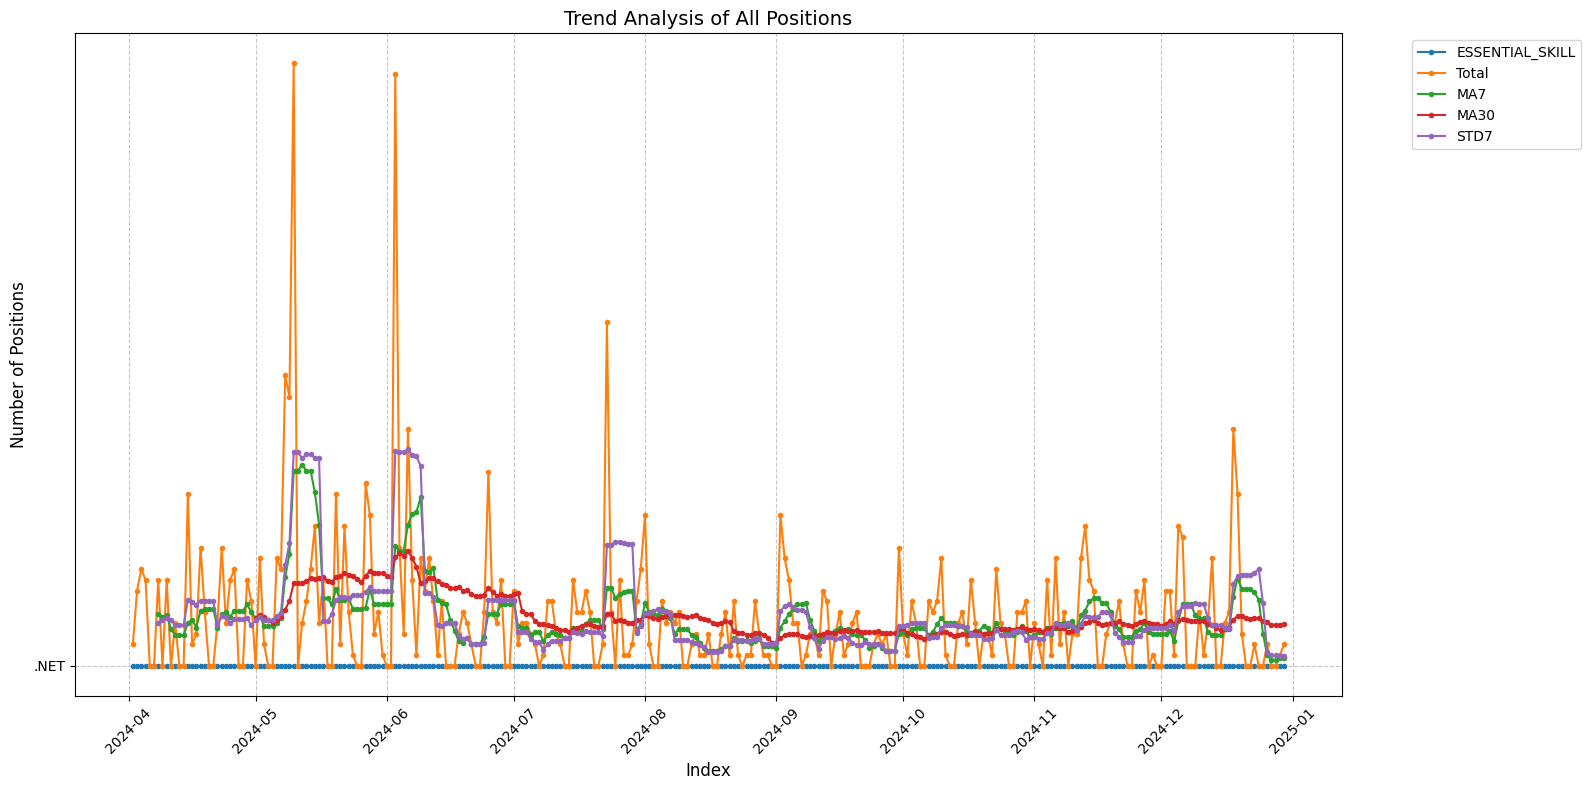

In [27]:
# Create a figure with specified size
plt.figure(figsize=(16, 8))

# Plot all columns
for column in tdf.columns:
    plt.plot(tdf[column], label=column, marker='.')

# Customize the plot
plt.title('Trend Analysis of All Positions', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Number of Positions', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
reg = xgb.XGBRegressor()

In [1]:
%pip install nltk gensim wordcloud

Note: you may need to restart the kernel to use updated packages.
